# Predictions using Machine Learning Models - Zoom in Spain

In [1]:
# Essential libraries: 
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = "plotly_white"
from plotly.subplots import make_subplots

# import folium
%matplotlib inline

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Prediction Models
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.set_option('display.float_format', lambda x: '%.6f' % x)

## a) Confirmed cases

In [2]:
spain_confirmed = pd.read_csv("https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_casos_long.csv")
spain_confirmed = spain_confirmed.drop(['cod_ine'], axis=1)
spain_confirmed.rename(columns={'total': 'Confirmed'}, inplace=True)
spain_confirmed.head()

,fecha,CCAA,Confirmed
0,2020-02-27,Andalucía,1
1,2020-02-28,Andalucía,6
2,2020-02-29,Andalucía,8
3,2020-03-01,Andalucía,12
4,2020-03-02,Andalucía,12


In [3]:
spain_deaths = pd.read_csv('https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_fallecidos_long.csv')
spain_deaths = spain_deaths.drop(['cod_ine'], axis=1)
spain_deaths.rename(columns={'total': 'Deaths'}, inplace=True)
spain_deaths.head()

,fecha,CCAA,Deaths
0,2020-03-03,Andalucía,0
1,2020-03-04,Andalucía,0
2,2020-03-05,Andalucía,0
3,2020-03-06,Andalucía,0
4,2020-03-07,Andalucía,0


In [4]:
spain = spain_confirmed.merge(spain_deaths, on=['fecha','CCAA'], how='inner')
spain.rename(columns={'fecha': 'Date'}, inplace=True)
spain.head()

,Date,CCAA,Confirmed,Deaths
0,2020-03-03,Andalucía,13,0
1,2020-03-04,Andalucía,13,0
2,2020-03-05,Andalucía,12,0
3,2020-03-06,Andalucía,21,0
4,2020-03-07,Andalucía,27,0


In [5]:
spain["Date"]=pd.to_datetime(spain["Date"])

In [6]:
datewise=spain.groupby(["Date"]).agg({"Confirmed":'sum',"Deaths":'sum'})
datewise.head()

,Confirmed,Deaths
Date,,
2020-03-03,300,0
2020-03-04,396,2
2020-03-05,474,6
2020-03-06,730,10
2020-03-07,860,16


In [7]:
datewise.dtypes

Confirmed    int64
Deaths       int64
dtype: object

In [8]:
datewise['Date'] = datewise.index
datewise

,Confirmed,Deaths,Date
Date,,,
2020-03-03,300,0,2020-03-03
2020-03-04,396,2,2020-03-04
2020-03-05,474,6,2020-03-05
2020-03-06,730,10,2020-03-06
2020-03-07,860,16,2020-03-07
2020-03-08,1178,34,2020-03-08
2020-03-09,1998,34,2020-03-09
2020-03-10,3244,70,2020-03-10
2020-03-11,4256,94,2020-03-11


In [9]:
datewise.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2020-03-03 to 2020-04-06
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Confirmed  35 non-null     int64         
 1   Deaths     35 non-null     int64         
 2   Date       35 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 KB


In [10]:
datewise.dtypes

Confirmed             int64
Deaths                int64
Date         datetime64[ns]
dtype: object

In [11]:
datewise.to_csv('data_pred.csv')

### 1. Lineal Regression Model for Confirm Cases Prediction

In [12]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from datetime import timedelta
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [13]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [14]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.85)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.85):]
model_scores=[]

In [15]:
train_ml.head()

,Confirmed,Deaths,Date,Days Since
Date,,,,
2020-03-03,300,0,2020-03-03,0
2020-03-04,396,2,2020-03-04,1
2020-03-05,474,6,2020-03-05,2
2020-03-06,730,10,2020-03-06,3
2020-03-07,860,16,2020-03-07,4


In [16]:
valid_ml.head()

,Confirmed,Deaths,Date,Days Since
Date,,,,
2020-04-01,204272,18106,2020-04-01,29
2020-04-02,220476,20006,2020-04-02,30
2020-04-03,235420,21870,2020-04-03,31
2020-04-04,249472,23488,2020-04-04,32
2020-04-05,261518,24836,2020-04-05,33


In [17]:
train_ml.shape, valid_ml.shape

((29, 4), (6, 4))

In [18]:
lin_reg=LinearRegression(normalize=True)

In [19]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [20]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [21]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  80950.44394161373


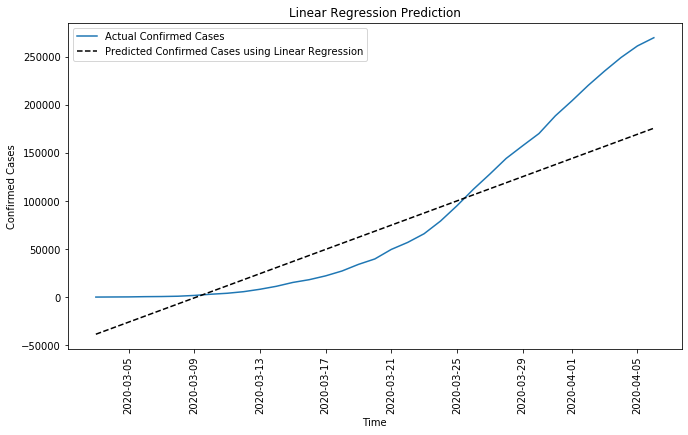

In [22]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Actual Confirmed Cases")
plt.plot(datewise.index,prediction_linreg, linestyle='--',label="Predicted Confirmed Cases using Linear Regression",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Linear Regression Prediction")
plt.xticks(rotation=90)
plt.legend()

### 2. Support Vector Machine ModelRegressor for Prediction of Confirmed Cases

In [24]:
#Intializing SVR Model and with hyperparameters for GridSearchCV
svm=SVR(C=1,degree=8,kernel='poly',epsilon=0.01)

In [25]:
#Performing GridSearchCV to find the Best Estimator
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=8, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [27]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  564630.7413399613


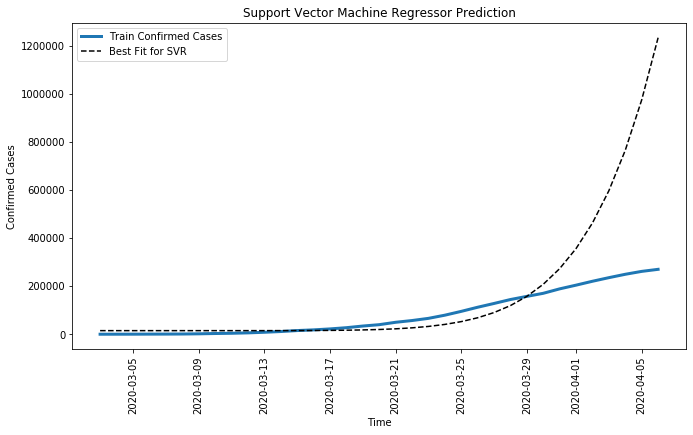

In [28]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
plt.plot(datewise["Confirmed"],label="Train Confirmed Cases",linewidth=3)
plt.plot(datewise.index,prediction_svm, linestyle='--',label="Best Fit for SVR",color='black')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases')
plt.title("Support Vector Machine Regressor Prediction")
plt.xticks(rotation=90)
plt.legend()

In [29]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [30]:
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_svm),columns=["Dates","Linear Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,SVM Prediction
0,2020-04-07,182235.020690,1550662.918062
1,2020-04-08,188537.282759,1938797.718178
2,2020-04-09,194839.544828,2410210.769907
3,2020-04-10,201141.806897,2979772.018000
4,2020-04-11,207444.068966,3664501.422830


### 3.  Times Series Forecasting

**Holt's Linear Model**

In [31]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.85)]
valid=datewise.iloc[int(datewise.shape[0]*0.85):]

In [32]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=1.3, smoothing_slope=1.1)
y_pred=valid.copy()

In [33]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  28669.520553705155


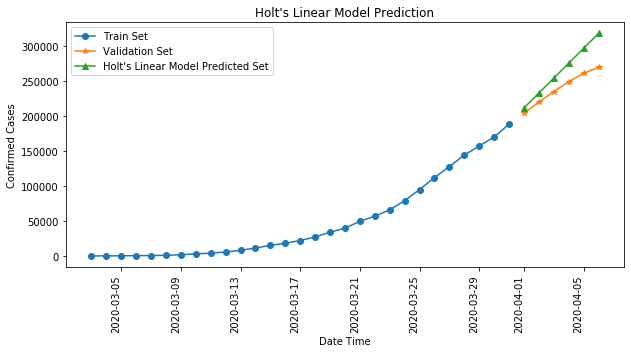

In [34]:
plt.figure(figsize=(10,5))
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred.Holt.plot(label="Holt's Linear Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Holt's Linear Model Prediction")
plt.xticks(rotation=90)
plt.legend()

In [35]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2020-04-07,182235.020690,1550662.918062,339931.639126
1,2020-04-08,188537.282759,1938797.718178,361254.525108
2,2020-04-09,194839.544828,2410210.769907,382577.411090
3,2020-04-10,201141.806897,2979772.018000,403900.297071
4,2020-04-11,207444.068966,3664501.422830,425223.183053


**Holt's Winter Model for Daily Time Series**

In [36]:
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=2,trend='mul', seasonal='add').fit()

In [37]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))

In [38]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  35233.34119398889


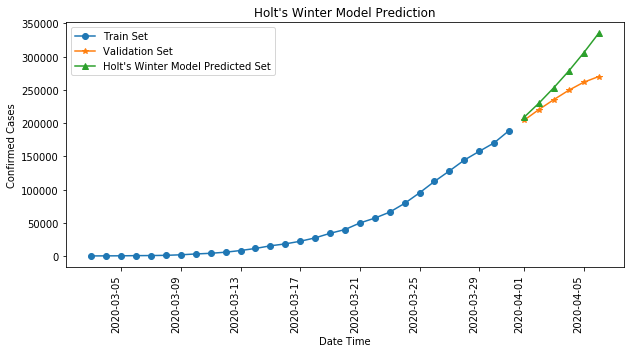

In [39]:
plt.figure(figsize=(10,5))
plt.plot(model_train.Confirmed,label="Train Set",marker='o')
valid.Confirmed.plot(label="Validation Set",marker='*')
y_pred["Holt\'s Winter Model"].plot(label="Holt's Winter Model Predicted Set",marker='^')
plt.ylabel("Confirmed Cases")
plt.xlabel("Date Time")
plt.title("Holt's Winter Model Prediction")
plt.xticks(rotation=90)
plt.legend()

In [40]:
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2020-04-07,182235.020690,1550662.918062,339931.639126,367011.942615
1,2020-04-08,188537.282759,1938797.718178,361254.525108,401410.472756
2,2020-04-09,194839.544828,2410210.769907,382577.411090,438847.080357
3,2020-04-10,201141.806897,2979772.018000,403900.297071,479170.419059
4,2020-04-11,207444.068966,3664501.422830,425223.183053,523020.500763


In [41]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.80)]
valid=datewise.iloc[int(datewise.shape[0]*0.80):]
y_pred=valid.copy()

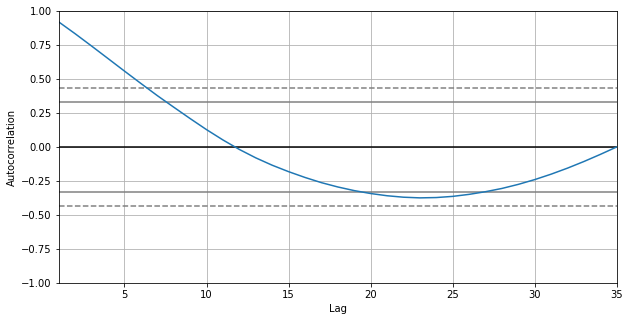

In [42]:
plt.figure(figsize=(10, 5))
autocorrelation_plot(datewise["Confirmed"])

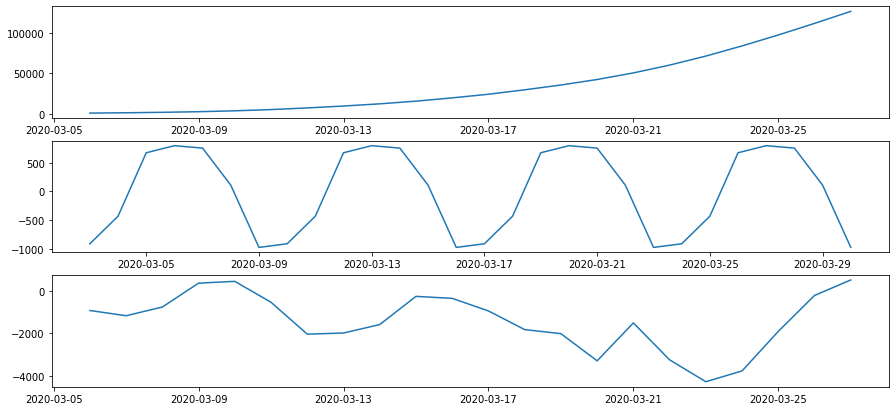

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize=(15,7))

results=sm.tsa.seasonal_decompose(model_train["Confirmed"])
ax1.plot(results.trend)
ax2.plot(results.seasonal)
ax3.plot(results.resid)

In [44]:
# We can see that it has a trend because the growth is exponential

In [45]:
print("Results of Dickey-Fuller test for Original Time Series")
dftest = adfuller(model_train["Confirmed"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller test for Original Time Series
Test Statistic                -0.377182
p-value                        0.913839
#Lags Used                     1.000000
Number of Observations Used   26.000000
Critical Value (1%)           -3.711212
Critical Value (5%)           -2.981247
Critical Value (10%)          -2.630095
dtype: float64


In [46]:
# If the P-value is close to 0 it means it is stationary. 

In [47]:
# We apply a logarithmic scale to correct the trend in order to be stationary. 
log_series=np.log(model_train["Confirmed"])

In [48]:
print("Results of Dickey-Fuller test for Log Transformed Time-Series")
dftest = adfuller(log_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller test for Log Transformed Time-Series
Test Statistic                -4.504191
p-value                        0.000193
#Lags Used                     0.000000
Number of Observations Used   27.000000
Critical Value (1%)           -3.699608
Critical Value (5%)           -2.976430
Critical Value (10%)          -2.627601
dtype: float64


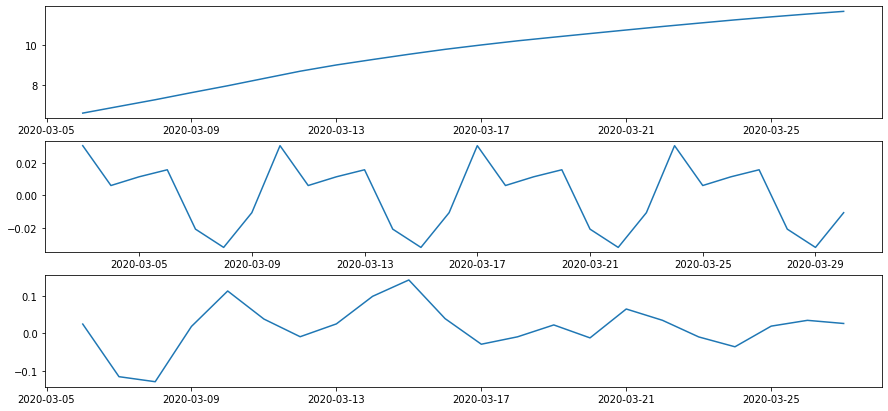

In [49]:
# We print the parameters again. And we see that the growth is more constant than the one we had before. The line is flatter. 
fig, (ax1,ax2,ax3) = plt.subplots(3, 1,figsize=(15,7))

results=sm.tsa.seasonal_decompose(log_series)
ax1.plot(results.trend)
ax2.plot(results.seasonal)
ax3.plot(results.resid)

**AR MODEL**

In [50]:
# Ho fa amb el log i dp fa un fit amb l'interval de predicció: 
model_ar=ARIMA(log_series,(1,1,0))
model_ar_fit=model_ar.fit()

In [51]:
# Torna amb les dades originals amb el exp:
prediction_ar=model_ar_fit.forecast(len(valid))[0]
y_pred["AR Model Prediction"]=list(np.exp(prediction_ar))

In [52]:
model_scores.append(np.sqrt(mean_squared_error(list(valid["Confirmed"]),np.exp(prediction_ar))))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(list(valid["Confirmed"]),np.exp(prediction_ar))))

Root Mean Square Error for AR Model:  224007.02918413695


(array([737489., 737493., 737497., 737501., 737505., 737509., 737513.,
        737516., 737520.]),
 <a list of 9 Text xticklabel objects>)

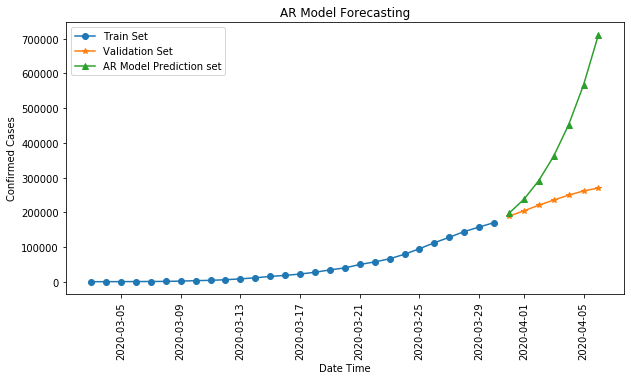

In [53]:
plt.figure(figsize=(10,5))
plt.plot(model_train.index,model_train["Confirmed"],label="Train Set",marker='o')
plt.plot(valid.index,valid["Confirmed"],label="Validation Set",marker='*')
plt.plot(y_pred["AR Model Prediction"],label="AR Model Prediction set",marker="^")
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("AR Model Forecasting")
plt.xticks(rotation=90)

In [54]:
# Aqui ens diu segons cada model, el numero de casos que prediuen per cada fecha:
AR_model_new_prediction=[]
for i in range(1,18):
    AR_model_new_prediction.append(np.exp(model_ar_fit.forecast(len(valid)+i)[0][-1]))
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2020-04-07,182235.020690,1550662.918062,339931.639126,367011.942615,894764.225809
1,2020-04-08,188537.282759,1938797.718178,361254.525108,401410.472756,1125596.872111
2,2020-04-09,194839.544828,2410210.769907,382577.411090,438847.080357,1416414.969936
3,2020-04-10,201141.806897,2979772.018000,403900.297071,479170.419059,1782671.175144
4,2020-04-11,207444.068966,3664501.422830,425223.183053,523020.500763,2243840.837438


**MA Model**

In [55]:
# Utilitza el rolling per agafar valors passats i fas la mitjana. El MA va be perque tenen tendencia a pujar i com això és exponencial va be. 
model_train=datewise.iloc[:int(datewise.shape[0]*0.85)]
valid=datewise.iloc[int(datewise.shape[0]*0.85):]
log_series=np.log(model_train["Confirmed"])
y_pred=valid.copy()

In [56]:
model_ma=ARIMA(log_series,(0,1,5))
model_ma_fit=model_ma.fit()

In [57]:
prediction_ma=model_ma_fit.forecast(len(valid))[0]
y_pred["MA Model Prediction"]=list(np.exp(prediction_ma))

In [58]:
model_scores.append(np.sqrt(mean_squared_error(list(valid["Confirmed"]),np.exp(prediction_ma))))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(list(valid["Confirmed"]),np.exp(prediction_ma))))

Root Mean Square Error for MA Model:  112418.44745133014


(array([737489., 737493., 737497., 737501., 737505., 737509., 737513.,
        737516., 737520.]),
 <a list of 9 Text xticklabel objects>)

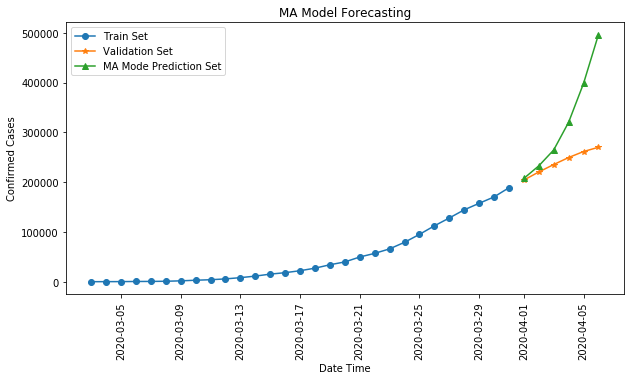

In [59]:
plt.figure(figsize=(10,5))
plt.plot(model_train.index,model_train["Confirmed"],label="Train Set",marker='o')
plt.plot(valid.index,valid["Confirmed"],label="Validation Set",marker='*')
plt.plot(y_pred["MA Model Prediction"],label="MA Mode Prediction Set",marker='^')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("MA Model Forecasting")
plt.xticks(rotation=90)

In [60]:
MA_model_new_prediction=[]
for i in range(1,18):
    MA_model_new_prediction.append(np.exp(model_ma_fit.forecast(len(valid)+i)[0][-1]))
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2020-04-07,182235.020690,1550662.918062,339931.639126,367011.942615,894764.225809,618243.878356
1,2020-04-08,188537.282759,1938797.718178,361254.525108,401410.472756,1125596.872111,770352.146104
2,2020-04-09,194839.544828,2410210.769907,382577.411090,438847.080357,1416414.969936,959884.035706
3,2020-04-10,201141.806897,2979772.018000,403900.297071,479170.419059,1782671.175144,1196046.985348
4,2020-04-11,207444.068966,3664501.422830,425223.183053,523020.500763,2243840.837438,1490313.764941


**ARIMA Model**

In [61]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.80)]
valid=datewise.iloc[int(datewise.shape[0]*0.80):]
log_series=np.log(model_train["Confirmed"])
y_pred=valid.copy()

In [62]:
model_arima=ARIMA(log_series,(2,1,1))
model_arima_fit=model_arima.fit()

In [63]:
prediction_arima=model_arima_fit.forecast(len(valid))[0]
y_pred["ARIMA Model Prediction"]=list(np.exp(prediction_arima))

In [64]:
model_scores.append(np.sqrt(mean_squared_error(list(valid["Confirmed"]),np.exp(prediction_arima))))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(list(valid["Confirmed"]),np.exp(prediction_arima))))

Root Mean Square Error for ARIMA Model:  108165.59754272221


(array([737489., 737493., 737497., 737501., 737505., 737509., 737513.,
        737516., 737520.]),
 <a list of 9 Text xticklabel objects>)

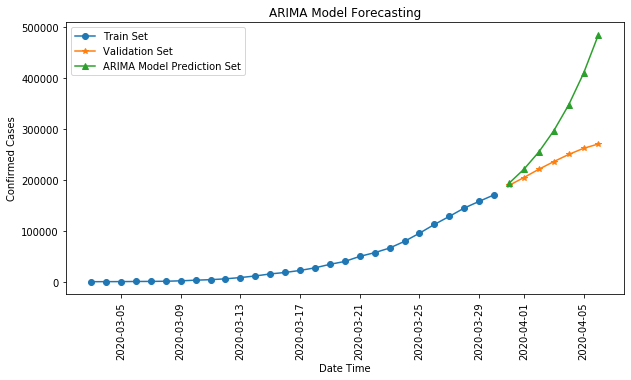

In [65]:
plt.figure(figsize=(10,5))
plt.plot(model_train.index,model_train["Confirmed"],label="Train Set",marker='o')
plt.plot(valid.index,valid["Confirmed"],label="Validation Set",marker='*')
plt.plot(y_pred["ARIMA Model Prediction"],label="ARIMA Model Prediction Set",marker='^')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("ARIMA Model Forecasting")
plt.xticks(rotation=90)

In [66]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(np.exp(model_arima_fit.forecast(len(valid)+i)[0][-1]))
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2020-04-07,182235.020690,1550662.918062,339931.639126,367011.942615,894764.225809,618243.878356,577235.426073
1,2020-04-08,188537.282759,1938797.718178,361254.525108,401410.472756,1125596.872111,770352.146104,691210.349737
2,2020-04-09,194839.544828,2410210.769907,382577.411090,438847.080357,1416414.969936,959884.035706,831076.991118
3,2020-04-10,201141.806897,2979772.018000,403900.297071,479170.419059,1782671.175144,1196046.985348,1002886.060524
4,2020-04-11,207444.068966,3664501.422830,425223.183053,523020.500763,2243840.837438,1490313.764941,1214138.131599


**Summarization of forecats using different Models**

In [67]:
model_names=["Linear Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model"]
pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])

,Model Name,Root Mean Squared Error
2,Holt's Linear,28669.520554
3,Holt's Winter Model,35233.341194
0,Linear Regression,80950.443942
6,ARIMA Model,108165.597543
5,Moving Average Model (MA),112418.447451
4,Auto Regressive Model (AR),224007.029184
1,Support Vector Machine Regressor,564630.741340


## b) Death Cases

### 1. Time Series Forecasting

(array([737489., 737493., 737497., 737501., 737505., 737509., 737513.,
        737516., 737520.]),
 <a list of 9 Text xticklabel objects>)

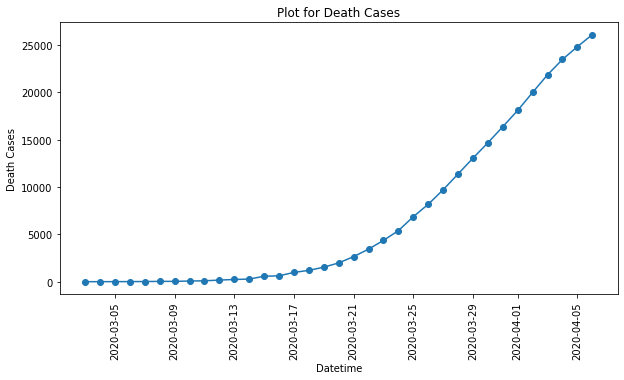

In [68]:
plt.figure(figsize=(10,5))
plt.plot(datewise["Deaths"],marker='o')
plt.ylabel("Death Cases")
plt.xlabel("Datetime")
plt.title("Plot for Death Cases")
plt.xticks(rotation=90)

In [69]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.85)]
valid=datewise.iloc[int(datewise.shape[0]*0.85):]
y_pred=valid.copy()

In [70]:
print("Results of Dickey-Fuller test for Original Time Series")
dftest = adfuller(model_train["Deaths"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller test for Original Time Series
Test Statistic                -3.256464
p-value                        0.016940
#Lags Used                     3.000000
Number of Observations Used   25.000000
Critical Value (1%)           -3.723863
Critical Value (5%)           -2.986489
Critical Value (10%)          -2.632800
dtype: float64


In [122]:
log_deaths=(model_train["Deaths"])
print("Results of Dickey-Fuller test for Original Time Series")
dftest = adfuller((log_deaths).dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller test for Original Time Series
Test Statistic                -3.256464
p-value                        0.016940
#Lags Used                     3.000000
Number of Observations Used   25.000000
Critical Value (1%)           -3.723863
Critical Value (5%)           -2.986489
Critical Value (10%)          -2.632800
dtype: float64


In [123]:
log_deaths

Date
2020-03-03        0
2020-03-04        2
2020-03-05        6
2020-03-06       10
2020-03-07       16
2020-03-08       34
2020-03-09       34
2020-03-10       70
2020-03-11       94
2020-03-12      168
2020-03-13      238
2020-03-14      272
2020-03-15      576
2020-03-16      618
2020-03-17      982
2020-03-18     1196
2020-03-19     1534
2020-03-20     1984
2020-03-21     2652
2020-03-22     3440
2020-03-23     4364
2020-03-24     5392
2020-03-25     6868
2020-03-26     8178
2020-03-27     9716
2020-03-28    11380
2020-03-29    13056
2020-03-30    14680
2020-03-31    16378
Name: Deaths, dtype: int64

In [124]:
log_deaths = log_deaths[log_deaths != 0]

In [125]:
# NO FUNCIONA AMB LOG
no_log_deaths=np.log(model_train["Deaths"])
print("Results of Dickey-Fuller test for Original Time Series")
dftest = adfuller((log_deaths.diff().diff().diff()).dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller test for Original Time Series
Test Statistic                -1.678288
p-value                        0.442332
#Lags Used                     9.000000
Number of Observations Used   15.000000
Critical Value (1%)           -3.964443
Critical Value (5%)           -3.084908
Critical Value (10%)          -2.681814
dtype: float64


(array([737493., 737497., 737501., 737505., 737509., 737513., 737516.]),
 <a list of 7 Text xticklabel objects>)

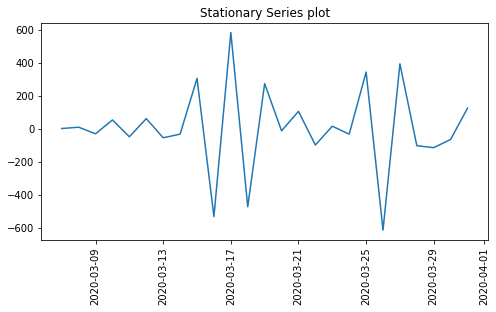

In [126]:
series=(log_deaths.diff().diff().diff()).dropna()
plt.figure(figsize=(8,4))
plt.plot(series)
plt.title("Stationary Series plot")
plt.xticks(rotation=90)

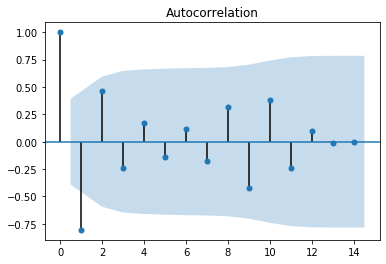

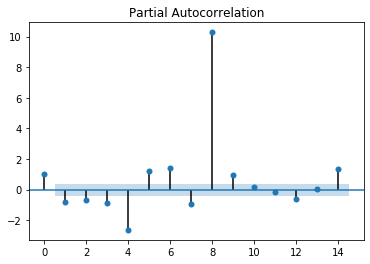

In [127]:
plot_acf(series)
plt.show()
plot_pacf(series)
plt.show()

In [128]:
model_arima_deaths=ARIMA(log_deaths,(2,2,1))

In [129]:
model_arima_deaths_fit=model_arima_deaths.fit()

In [130]:
predictions_deaths

array([18099.46313197, 19881.77679122, 21703.63153366, 23581.76719611,
       25507.34812161, 27487.97772505])

In [131]:
predictions_deaths=np.exp(model_arima_deaths_fit.forecast(len(valid))[0])
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [132]:
predictions_deaths=(model_arima_deaths_fit.forecast(len(valid))[0])
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [133]:
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [134]:
predictions_deaths

array([18099.46313197, 19881.77679122, 21703.63153366, 23581.76719611,
       25507.34812161, 27487.97772505])

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text xticklabel objects>)

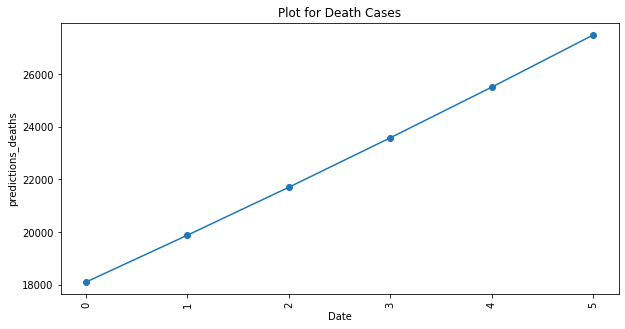

In [135]:
plt.figure(figsize=(10,5))
plt.plot(predictions_deaths,marker='o')
plt.ylabel("predictions_deaths")
plt.xlabel("Date")
plt.title("Plot for Death Cases")
plt.xticks(rotation=90)

In [136]:
test = np.exp(predictions_deaths)

In [137]:
test

array([inf, inf, inf, inf, inf, inf])

In [138]:
valid

,Confirmed,Deaths,Date,Days Since
Date,,,,
2020-04-01,204272,18106,2020-04-01,29
2020-04-02,220476,20006,2020-04-02,30
2020-04-03,235420,21870,2020-04-03,31
2020-04-04,249472,23488,2020-04-04,32
2020-04-05,261518,24836,2020-04-05,33
2020-04-06,270064,26110,2020-04-06,34


In [139]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  632.6499560081293


In [140]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  632.6499560081293


(array([737489., 737493., 737497., 737501., 737505., 737509., 737513.,
        737516., 737520.]),
 <a list of 9 Text xticklabel objects>)

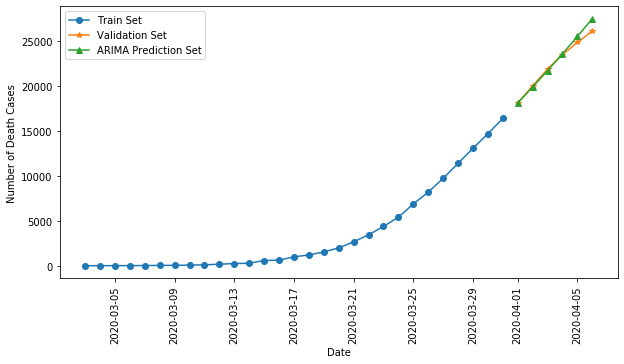

In [141]:
plt.figure(figsize=(10,5))
plt.plot(model_train["Deaths"],label="Train Set",marker="o")
plt.plot(valid["Deaths"],label="Validation Set",marker="*")
plt.plot(y_pred["ARIMA Death Prediction"],label="ARIMA Prediction Set",marker="^")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Number of Death Cases")
plt.xticks(rotation=90)

In [142]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(np.exp(model_arima_deaths_fit.forecast(len(valid)+i)[0][-1]))

In [143]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2020-04-07,inf
1,2020-04-08,inf
2,2020-04-09,inf
3,2020-04-10,inf
4,2020-04-11,inf
